In [1]:
import uproot, ROOT, glob, os, random
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
from sklearn.metrics import roc_curve, roc_auc_score
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier
from array import array
import ctypes
import h5py

Welcome to JupyROOT 6.28/04


In [2]:
def getXS(dsid):
    xs_file = "/cvmfs/atlas.cern.ch/repo/sw/database/GroupData/dev/PMGTools/PMGxsecDB_mc16.txt"
    try:
        with open(xs_file, "r") as f:
            for line in f:
                columns = line.split()
                if columns[0] == str(dsid):
                    return float(columns[2])*float(columns[3])*float(columns[4])
        print( "Couldn't find cross section for dsid", dsid, "so setting to 1.")
    except IOError:
        print("Cross section file not accessible on cvmfs.", dsid, " XS setting to 1.")
    return 1

def flattened_pt_weighted(data, bins, weight):
    weights = np.zeros(len(data))
    pt_hist, bin_edges = np.histogram(data, bins=bins, weights=weight)
    for i in range(len(pt_hist)):
        if pt_hist[i] == 0:
            weights = np.where((data >= bin_edges[i]) & (data < bin_edges[i+1]), 1, weights)
        else:
            weights = np.where((data >= bin_edges[i]) & (data < bin_edges[i+1]), 1/pt_hist[i], weights)

    return weights

path = '/global/homes/a/agarabag/pscratch/ditdau_samples/'

dataset_keys = ["event_id", "ditau_pt", "IsTruthHadronic",
                "f_core_lead", "f_core_subl", "f_subjet_subl", "f_subjets", "f_isotracks",
                "R_max_lead", "R_max_subl", "R_isotrack", "R_tracks_subl",
                "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl",
                "d0_leadtrack_lead", "d0_leadtrack_subl",
                "n_track", "n_tracks_lead", "n_tracks_subl", "n_subjets",
                "event_weight", "bdt_score"]

index = 0
ditau = h5py.File(path+f"ditau_flattened_{index}.h5")
ditau.keys()

<KeysViewHDF5 ['IsTruthHadronic', 'R_isotrack', 'R_max_lead', 'R_max_subl', 'R_tracks_subl', 'bdt_score', 'd0_leadtrack_lead', 'd0_leadtrack_subl', 'ditau_pt', 'event_id', 'event_weight', 'f_core_lead', 'f_core_subl', 'f_isotracks', 'f_subjet_subl', 'f_subjets', 'm_core_lead', 'm_core_subl', 'm_tracks_lead', 'm_tracks_subl', 'n_subjets', 'n_track', 'n_tracks_lead', 'n_tracks_subl']>

In [3]:
# H5 -> Panda DataFrame
# Cross Section
bkg_xs = [364700, 364701, 364702, 364703, 364704, 364705, 364706,
      364707, 364708, 364709, 364710, 364711, 364712]
graviton_xs = [425108, 425101, 425102, 425104, 425107]
gamma_xs = [425200]

# File Location
bkg_filelist = []
for index in tqdm(range(13)):
    bkg_filelist.append(f"ditau_flattened_{index}.h5")
    
graviton_filelist = ["graviton_flattened_M1000.h5",
                    "graviton_flattened_M1750.h5",
                    "graviton_flattened_M2000.h5",
                    "graviton_flattened_M2500.h5",
                    "graviton_flattened_M5000.h5"]
gamma_filelist = ["gamma_flattened_0.h5"]

# Selection Cut
def bkg_cut(df_chunk):
    return ((df_chunk['n_subjets'] >=2) &
           (df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6) &
           (((df_chunk['n_tracks_lead'] == 1) & (df_chunk['n_tracks_subl'] == 3)) |
            ((df_chunk['n_tracks_lead'] == 3) & (df_chunk['n_tracks_subl'] == 1))))

def signal_cut(df_chunk):
    return ((df_chunk['IsTruthHadronic']==1) & (df_chunk['n_subjets'] >=2) &
              (df_chunk['ditau_pt'] >= 2e5) & (df_chunk['ditau_pt'] <= 1e6) &
              (((df_chunk['n_tracks_lead'] == 1) & (df_chunk['n_tracks_subl'] == 3)) |
               ((df_chunk['n_tracks_lead'] == 3) & (df_chunk['n_tracks_subl'] == 1))))

# Define the chunk size
chunk_size = 10000000  # Adjust this size to suit your system's memory

# Define pT bins for pt weight
pt_bins = np.linspace(200000, 1000000, 41)

def h52panda(filelist, xs, cut):
    combined = pd.DataFrame()
    
    for index in range(len(filelist)):
        file_path = path + filelist[index]
    
        # Process the file in chunks
        with h5py.File(file_path, 'r') as h5_file:
            # Determine the total length of the datasets
            total_length = h5_file[dataset_keys[0]].shape[0]
            print(f'{filelist[index]}: {total_length}')

            # Read and process each chunk
            for chunk_start in range(0, total_length, chunk_size):
                chunk_end = chunk_start + chunk_size

                # Use slicing to read a chunk from each dataset in the HDF5 file
                data = {key: h5_file[key][chunk_start:chunk_end] for key in dataset_keys}

                # Convert the dictionary to a pandas DataFrame
                df_chunk = pd.DataFrame(data)

                # Apply Cut
                filtered_chunk = df_chunk[cut(df_chunk)]
                filtered_chunk = filtered_chunk.copy()
                filtered_chunk.loc[:, 'event_weight'] = filtered_chunk['event_weight'] * getXS(xs[index])

                combined = pd.concat([combined, filtered_chunk], ignore_index=True)
    
    combined['pT_weight'] = flattened_pt_weighted(combined['ditau_pt'], pt_bins, combined['event_weight'])

    return combined


100%|██████████| 13/13 [00:00<00:00, 251271.67it/s]


In [4]:
combined_gamma = h52panda(gamma_filelist, gamma_xs, signal_cut)

gamma_flattened_0.h5: 1507224


In [5]:
combined_graviton = h52panda(graviton_filelist, graviton_xs, signal_cut)

graviton_flattened_M1000.h5: 217986
graviton_flattened_M1750.h5: 319758
graviton_flattened_M2000.h5: 340018
graviton_flattened_M2500.h5: 359283
graviton_flattened_M5000.h5: 114803


In [6]:
combined_bkg = h52panda(bkg_filelist, bkg_xs, bkg_cut)

ditau_flattened_0.h5: 2464
ditau_flattened_1.h5: 3963
ditau_flattened_2.h5: 90828
ditau_flattened_3.h5: 101086942
ditau_flattened_4.h5: 285968626
ditau_flattened_5.h5: 137656105
ditau_flattened_6.h5: 21222249
ditau_flattened_7.h5: 9343864
ditau_flattened_8.h5: 10599522
ditau_flattened_9.h5: 4983206
ditau_flattened_10.h5: 1372916
ditau_flattened_11.h5: 368159
ditau_flattened_12.h5: 1328866


In [7]:
combined_gamma['event_weight']

0      2.144722e-10
1      2.144722e-10
2      2.144722e-10
3      2.144722e-10
4      2.144722e-10
           ...     
591    2.144722e-10
592    2.144722e-10
593    2.144722e-10
594    2.144722e-10
595    2.144722e-10
Name: event_weight, Length: 596, dtype: float32

In [8]:
combined_signal = pd.concat([combined_graviton, combined_gamma])
combined_signal['label'] = 1
combined_bkg['label'] = 0
df = pd.concat([combined_bkg, combined_signal])
df

,event_id,ditau_pt,IsTruthHadronic,f_core_lead,f_core_subl,f_subjet_subl,f_subjets,f_isotracks,R_max_lead,R_max_subl,...,d0_leadtrack_lead,d0_leadtrack_subl,n_track,n_tracks_lead,n_tracks_subl,n_subjets,event_weight,bdt_score,pT_weight,label
0,39027670,213657.031250,0,0.926703,0.443602,0.040013,0.677840,0.010481,0.074065,0.094681,...,0.009625,0.028497,4,3,1,2,4.011992e+03,0.411234,2.444456e-04,0
1,36880231,364533.812500,0,0.864005,0.397312,0.082795,0.864683,0.003509,0.010268,0.136225,...,0.013174,0.028572,4,1,3,2,4.011992e+03,0.607447,2.490135e-04,0
2,32951350,244184.171875,0,0.907845,0.480501,0.031790,0.738247,0.038568,0.175888,0.138438,...,0.206622,0.000000,4,3,1,2,4.011992e+03,0.395955,1.223512e-04,0
3,44888353,249081.375000,0,0.783342,0.129565,0.031296,0.760861,0.015647,0.168835,0.184362,...,0.000000,0.037705,4,3,1,2,4.011992e+03,0.445831,1.223512e-04,0
4,36079784,289045.937500,0,0.894528,0.246616,0.026755,0.729273,0.014855,0.055002,0.140860,...,0.002830,0.000000,4,3,1,2,9.602898e+01,0.394018,8.437428e-03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,31163332,526071.187500,1,0.910397,0.969296,0.104997,0.943490,0.000000,0.015913,0.023469,...,0.058029,-0.059134,4,3,1,2,2.144722e-10,0.799701,4.662652e+08,1
592,30334126,336502.468750,1,0.915086,0.163371,0.118368,0.814084,0.003424,0.013215,0.022163,...,-0.028529,-0.051443,5,3,1,3,2.144722e-10,0.716544,9.515616e+07,1
593,30541837,361832.781250,1,0.921741,0.790117,0.321459,0.791638,0.007923,0.008872,0.035717,...,-0.024883,0.030005,4,1,3,2,2.144722e-10,0.747290,1.227014e+08,1
594,30665541,267720.937500,1,0.791846,0.778316,0.255994,0.886948,0.003313,0.014343,0.010908,...,0.028992,-0.053649,4,3,1,2,2.144722e-10,0.729371,7.173202e+07,1


In [47]:
''' save the dataframe
df.to_csv('/eos/user/j/jlai/tau_test/combined_data.csv', index=False)
df = pd.read_csv('/eos/user/j/jlai/tau_test/combined_data.csv')
df
'''

" save the dataframe\ndf.to_csv('/eos/user/j/jlai/tau_test/combined_data.csv', index=False)\ndf = pd.read_csv('/eos/user/j/jlai/tau_test/combined_data.csv')\ndf\n"

In [73]:
#the order matters. needs to be kept like this. 
training_vars = ["f_core_lead", 
                "f_core_subl", 
                "f_subjet_subl", 
                "f_subjets", 
                "f_isotracks", 
                "R_max_lead",
                "R_max_subl", 
                "R_isotrack", 
                "R_tracks_subl",
                "m_core_lead",
                "m_core_subl", 
                "m_tracks_lead",
                "m_tracks_subl",
                "d0_leadtrack_lead",
                "d0_leadtrack_subl", 
                "n_track", 
                "n_tracks_lead"]


# Scrambling 
# Calculate the modulo of each eventID
# df['eventID_mod'] = df['event_id'] % 5
df['eventID_mod'] = df['event_id'] % 10


df['weight'] = df['event_weight'] * df['pT_weight']

log_vars = ["f_isotracks", "m_core_lead", "m_core_subl", "m_tracks_lead", "m_tracks_subl"]
abs_log_var = ["d0_leadtrack_lead", "d0_leadtrack_subl"]

# df[log_vars] = np.log(df[log_vars])
# df = df[~df[log_vars].isin([np.inf, -np.inf]).any(axis=1)]
# df[abs_log_var] = np.log(np.abs(df[abs_log_var]))
# df = df[~df[abs_log_var].isin([np.inf, -np.inf]).any(axis=1)]

df.loc[:, log_vars] = np.log(df[log_vars])
df.loc[:, abs_log_var] = np.abs(np.log(df[abs_log_var]))
df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# train_df = df[df['eventID_mod'] < 4] # 80%
# test_df = df[df['eventID_mod'] == 4] # 20%
train_df = df[df['eventID_mod'] < 7] # 70%
test_df = df[df['eventID_mod'] >= 7] # 30%

train_df = train_df.drop(columns='eventID_mod')
test_df = test_df.drop(columns='eventID_mod')

# Training & Testing sets
training_data, testing_data, training_labels, testing_labels, training_weights, testing_weights = \
train_df[training_vars], test_df[training_vars], train_df['label'], test_df['label'], train_df['weight'], test_df['weight']

#Change column names to integers if needed (for ML models that expect numerical feature names)
feature_mapping = {feature: i for i, feature in enumerate(training_data.columns)}
training_data.rename(columns=feature_mapping, inplace=True)
feature_mapping = {feature: i for i, feature in enumerate(testing_data.columns)}
testing_data.rename(columns=feature_mapping, inplace=True)

# print(training_data)

print("training data: ", training_data.shape)
print("training labels: ", training_labels.shape)
print("training weights: ", training_weights.shape)
print("testing data: ", testing_data.shape)
print("testing labels: ", testing_labels.shape)
print("testing weights: ", testing_weights.shape)
print("testing ratio: ", testing_weights.shape[0]/(testing_weights.shape[0]+training_data.shape[0]))

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/tmp/ipykernel_1817621/1781693413.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.rename(columns=feature_mapping, inplace=True)
/tmp/ipykernel_1817621/1781693413.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

training data:  (875019, 17)
training labels:  (875019,)
training weights:  (875019,)
testing data:  (374989, 17)
testing labels:  (374989,)
testing weights:  (374989,)
testing ratio:  0.29998928006860753


In [74]:
# create the BDT
params = {
'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200,
'eval_metric': 'logloss',
'random_state': 0,
'gamma': 0.001,
'verbosity': 2
}
bdt = XGBClassifier(**params)

# Train the classifier
bdt.fit(training_data, training_labels, eval_set=[(testing_data, testing_labels)], sample_weight=training_weights)

[0]	validation_0-logloss:0.87555
[1]	validation_0-logloss:0.80156
[2]	validation_0-logloss:0.74042
[3]	validation_0-logloss:0.68245
[4]	validation_0-logloss:0.63074
[5]	validation_0-logloss:0.58416
[6]	validation_0-logloss:0.54266
[7]	validation_0-logloss:0.51302
[8]	validation_0-logloss:0.48129
[9]	validation_0-logloss:0.45244
[10]	validation_0-logloss:0.42914
[11]	validation_0-logloss:0.40785
[12]	validation_0-logloss:0.38828
[13]	validation_0-logloss:0.37399
[14]	validation_0-logloss:0.35666
[15]	validation_0-logloss:0.34165
[16]	validation_0-logloss:0.32756
[17]	validation_0-logloss:0.31644
[18]	validation_0-logloss:0.30820
[19]	validation_0-logloss:0.29912
[20]	validation_0-logloss:0.29019
[21]	validation_0-logloss:0.28372
[22]	validation_0-logloss:0.27470
[23]	validation_0-logloss:0.26768
[24]	validation_0-logloss:0.26169
[25]	validation_0-logloss:0.25684
[26]	validation_0-logloss:0.25244
[27]	validation_0-logloss:0.24609
[28]	validation_0-logloss:0.24119
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.001, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

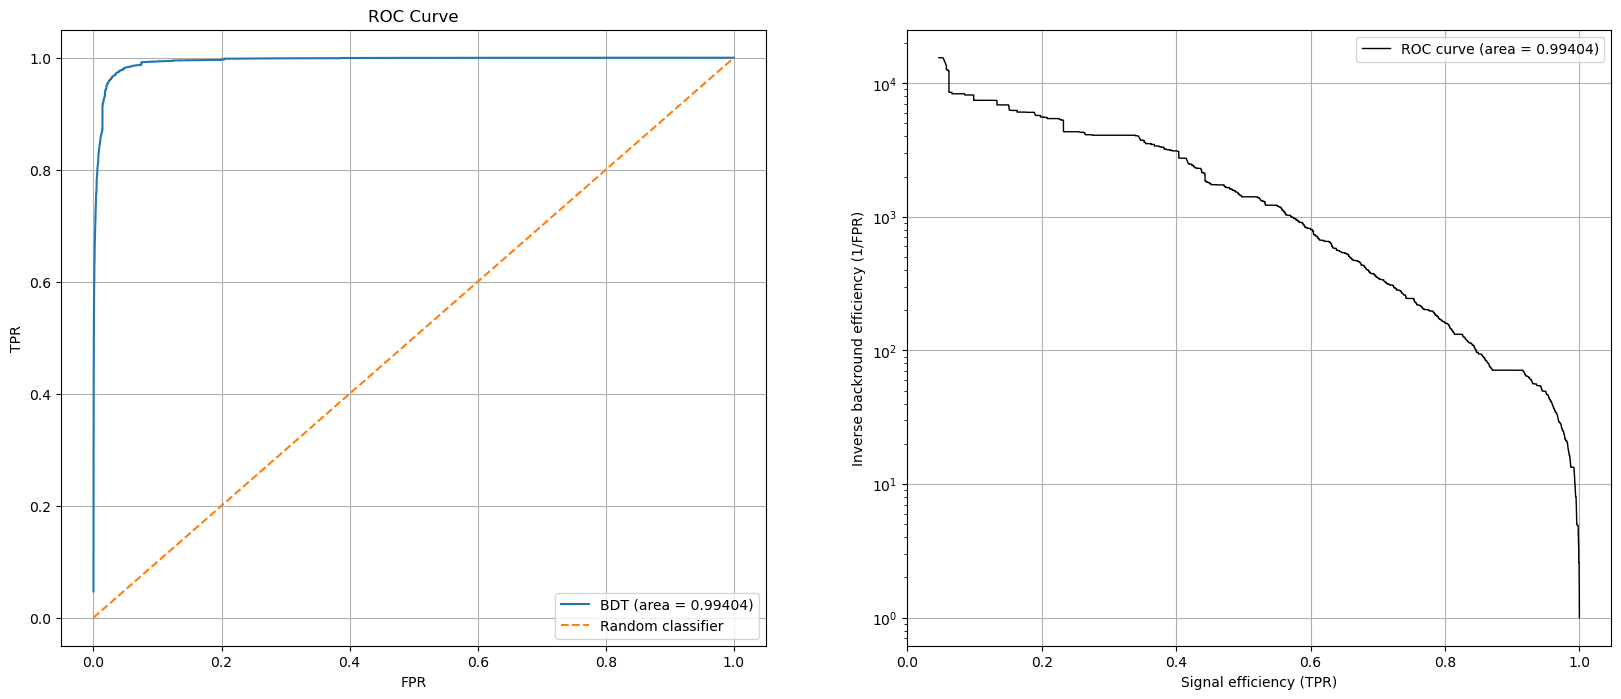

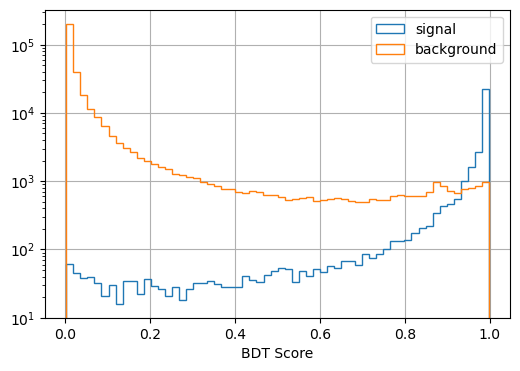

In [75]:
# Predict probabilities for the testing data
probs = bdt.predict_proba(testing_data)
probs = probs[:, 1]

fpr_w, tpr_w, thresholds_w = roc_curve(testing_labels, probs, sample_weight=testing_weights)
auc_w = roc_auc_score(testing_labels, probs, sample_weight=testing_weights)

non_zero_indices = np.nonzero(fpr_w)
tpr_w = tpr_w[non_zero_indices]
fpr_w = fpr_w[non_zero_indices]

plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.plot(fpr_w, tpr_w, label='BDT (area = {:.5f})'.format(auc_w))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(tpr_w, 1/fpr_w, color='black', lw=1, label='ROC curve (area = %0.5f)' % auc_w)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse backround efficiency (1/FPR)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(probs[testing_labels==1], bins=60, label='signal', histtype='step')
plt.hist(probs[testing_labels==0], bins=60, label='background', histtype='step')
plt.xlabel('BDT Score')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
bdt.save_model('bdt_results/xgb_model.model')

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:40:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [34]:
# Old Code
combined_data = df.sample(frac=1, random_state=42).reset_index(drop=True)

pd_data = combined_data[training_vars]
pd_weights = combined_data["weight"]
pd_labels = combined_data["label"]

feature_mapping = {feature: i for i, feature in enumerate(pd_data.columns)}
pd_data.rename(columns=feature_mapping, inplace=True)

# split the data into training and testing sets
training_data = pd_data[:int(len(pd_data)*0.8)]
training_labels = pd_labels[:int(len(pd_labels)*0.8)]
training_weights = pd_weights[:int(len(pd_weights)*0.8)]
print("training data: ", training_data.shape)
print("training labels: ", training_labels.shape)
print("training weights: ", training_weights.shape)

testing_data = pd_data[int(len(pd_data)*0.8):]
testing_labels = pd_labels[int(len(pd_labels)*0.8):]
testing_weights = pd_weights[int(len(pd_weights)*0.8):]
print("testing data: ", testing_data.shape)
print("testing labels: ", testing_labels.shape)
print("testing weights: ", testing_weights.shape)

from xgboost import XGBClassifier

# create the BDT

params = {
'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150,
'eval_metric': 'logloss',
'random_state': 0,
'gamma': 0.001,
'verbosity': 2
}
bdt = XGBClassifier(**params)
print(type(bdt))

# Train the classifier
# bdt.fit(training_data, training_labels, sample_weight=training_weights)
bdt.fit(training_data, training_labels, eval_set=[(testing_data, testing_labels)], sample_weight=training_weights)

/tmp/ipykernel_462/4224524376.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_data.rename(columns=feature_mapping, inplace=True)


training data:  (403712, 17)
training labels:  (403712,)
training weights:  (403712,)
testing data:  (100928, 17)
testing labels:  (100928,)
testing weights:  (100928,)
<class 'xgboost.sklearn.XGBClassifier'>
[23:43:55] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-logloss:0.66358
[23:43:55] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-logloss:0.63561
[23:43:55] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/xgboost-1.7.3/src/xgboost/1.7.3/src/tree/updater_prune.cc:98: tree pruning end, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-logloss:0.61217
[23:43:55] INFO: /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.001, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=0, ...)

/tmp/ipykernel_462/1924533157.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc)


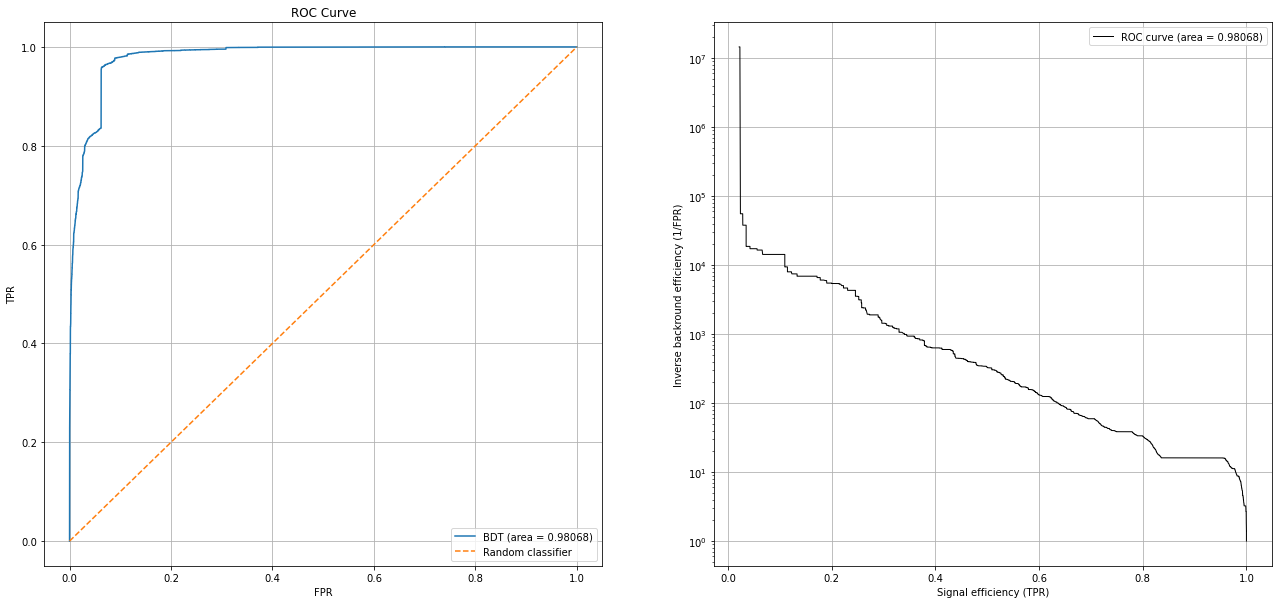

In [37]:
# Predict probabilities for the testing data
probs = bdt.predict_proba(testing_data)
probs = probs[:, 1]

fpr_w, tpr_w, thresholds_w = roc_curve(testing_labels, probs, sample_weight=testing_weights)
auc_w = roc_auc_score(testing_labels, probs, sample_weight=testing_weights)
plt.figure(figsize=(22, 10))
plt.subplot(121)
plt.plot(fpr_w, tpr_w, label='BDT (area = {:.5f})'.format(auc_w))
plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(tpr, 1/fpr, color='black', lw=1, label='ROC curve (area = %0.5f)' % roc_auc)
plt.xlabel('Signal efficiency (TPR)')
plt.ylabel('Inverse backround efficiency (1/FPR)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()